In [3]:
import SimpleITK as sitk
import numpy as np
import torch
import pandas as pd
import monai.metrics as met

In [2]:
data = data = pd.read_csv('/Users/joemarsilla/Downloads/deep_.csv', index_col=0)

In [3]:
data.head()

,0,1
0,/cluster/projects/radiomics/EXTERNAL/DeepMind/...,/cluster/projects/radiomics/EXTERNAL/DeepMind/...
1,/cluster/projects/radiomics/EXTERNAL/DeepMind/...,/cluster/projects/radiomics/EXTERNAL/DeepMind/...
2,/cluster/projects/radiomics/EXTERNAL/DeepMind/...,/cluster/projects/radiomics/EXTERNAL/DeepMind/...
3,/cluster/projects/radiomics/EXTERNAL/DeepMind/...,/cluster/projects/radiomics/EXTERNAL/DeepMind/...
4,/cluster/projects/radiomics/EXTERNAL/DeepMind/...,/cluster/projects/radiomics/EXTERNAL/DeepMind/...


In [4]:
pats = list(data['0'])

In [5]:
p = [p.split('/')[-2] for p in pats]

In [105]:
p = list(set(p))

In [6]:
from collections import OrderedDict
p = OrderedDict((x, True) for x in p).keys()

In [7]:
p = list(p)

In [9]:
p

['0522c0427',
 '0522c0773',
 '0522c0519',
 '0522c0667',
 '0522c0248',
 'TCGA-CV-A6K0',
 '0522c0251',
 '0522c0419',
 '0522c0768',
 '0522c0457',
 'TCGA-CV-A6JO',
 'TCGA-CV-5978',
 '0522c0659',
 '0522c0727b',
 'TCGA-CV-7236',
 '0522c0057',
 '0522c0727a',
 '0522c0226',
 'TCGA-CV-7245',
 'TCGA-CV-7243',
 '0522c0576',
 '0522c0416',
 'TCGA-CV-A6K1',
 'TCGA-CV-A6JY',
 '0522c0014',
 '0522c0629',
 '0522c0669',
 '0522c0845',
 '0522c0770',
 '0522c0708',
 '0522c0479',
 '0522c0017',
 'TCGA-CV-5977',
 '0522c0331',
 '0522c0161']

In [10]:
deep_classes = ['Brainstem','Lens-Lt', 'Lens-Rt', 'Mandible', 'Optic-Nerve-Lt', 'Optic-Nerve-Rt', 'Parotid-Lt', 'Parotid-Rt', 'Orbit-Lt', 'Orbit-Rt', 'Spinal-Cord', 'Spinal-Canal']
deep_classes2 = ['Brainstem','Lens_Lt', 'Lens_Rt', 'Mandible', 'Optic_Nerve_Lt', 'Optic_Nerve_Rt', 'Parotid_Lt', 'Parotid_Rt', 'Orbit_Lt', 'Orbit_Rt', 'Spinal_Cord', 'Spinal_Canal']
index_ = [1, 12, 13, 5, 16, 17, 6, 7, 14, 15, 2, 2]
chosen = ['BSTEM','SPCOR','ESOPH','LARYNX','MAND','LPAR','RPAR','LACOU','RACOU','RPLEX','LPLEX','LLENS','RLENS','LEYE','REYE','LOPTIC','ROPTIC','CHIASM','LIPS']

In [11]:
len(index_)

12

In [12]:
len(deep_classes)

12

In [14]:
# import torch, numpy as np, warnings
# this is the function to one-hot-encode data
def onehot(outs, targ, argmax=True):
    # Metrics requiring one hot encoded targets, pass through sigmoid or softmax
    # convert to one hot encoded target...
    shape = targ.size()
    print(len(shape), shape, outs.size())
    batch = shape[0]
    # calculate argmax...
    if argmax is True:
        outs = torch.softmax(outs, dim=1)
        outs = torch.argmax(outs, dim=1)
    
    class_ = int(torch.max(targ).item())
    print(class_)
    
    if len(shape) == 4:
        sh = (batch, class_ + 1, shape[1], shape[2], shape[3])
        print(sh)
        targets_dice = torch.zeros(sh, dtype=torch.float)
        targets_out = torch.zeros(sh, dtype=torch.float)
    else:
        sh = (1, class_ + 1, shape[0], shape[1], shape[2])
        print(sh)
        targets_dice = torch.zeros(sh, dtype=torch.float)
        targets_out = torch.zeros(sh, dtype=torch.float)

    for i in range( class_ + 1):
        targets_dice[0, i][targ[0] == i] = 1
        targets_out[0, i][outs[0] == i] = 1

    return targets_out, targets_dice


In [13]:
def resample_sitk(image, mode="linear", new_spacing=None, filter=False ): # new_spacing=np.array((1.0, 1.0, 2.0)) , filter=True
    if new_spacing is not None: # originally taken from https://github.com/SimpleITK/SimpleITK/issues/561
        resample = sitk.ResampleImageFilter()
        if mode == "linear":
            resample.SetInterpolator = sitk.sitkLinear  # use linear to resample image
        else: # use sitkNearestNeighbor interpolation # best for masks
            resample.SetInterpolator = sitk.sitkNearestNeighbor
        orig_size = np.array(image.GetSize(), dtype=np.int)
        orig_spacing = np.array(image.GetSpacing())
        resample.SetOutputDirection(image.GetDirection())
        resample.SetOutputOrigin(image.GetOrigin())
        resample.SetOutputPixelType(image.GetPixelIDValue())
        new_spacing = new_spacing
        resample.SetOutputSpacing(new_spacing)
        new_size = orig_size * (orig_spacing / new_spacing)
        new_size = np.ceil(new_size).astype(np.int)
        new_size = [int(s) for s in new_size]
        resample.SetSize(new_size)
        if filter is True: # fights artifacts produced by analaising # only do this when resampling image (not mask...)
            img = resample.Execute(sitk.SmoothingRecursiveGaussian(image, 2.0))
        else:
            img = resample.Execute(image)
    else: # do nothing to the image...
        img = image
    return img

In [22]:
oars = []
deep_oars = []
dce =  []
hd =   []
sd =   []
ob = []
p_ = []

In [25]:
# path of folders...
observer = 'radiographer'
path = f'/Users/joemarsilla/Documents/DeepMind/{observer}/' 

for i, pat in enumerate(p):
    path_ = path+pat+'/segmentations/'
    # load subsequent patient outputs from model...
    out_path = f"/Users/joemarsilla/Downloads/deepmind_ai_preds/outs_{i}_FULL.npy"
    outputs = torch.from_numpy(np.load(out_path))
#     targets = torch.from_numpy(np.load(out_path.replace('outs', 'in')))
    outputs, _ = onehot(outputs.unsqueeze(0), outputs.unsqueeze(0), argmax=False)
    
    for k, val in enumerate(index_):
        try:
            targ = sitk.ReadImage(path_+deep_classes[k]+'.nrrd')
        except Exception:
            targ = sitk.ReadImage(path_+deep_classes2[k]+'.nrrd')
#       img = self.resample_sitk(img, new_spacing=np.array((1.0, 1.0, 2.0)))
#         targ = resample_sitk(targ, mode="nearest", new_spacing=np.array((1.0, 1.0, 2.0)))
        targ = torch.tensor(sitk.GetArrayFromImage(targ))
        outs = outputs[0,val]
        dc = met.compute_meandice(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0))
        h  = met.compute_hausdorff_distance(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0), percentile=95, include_background=False)
        s  = met.compute_average_surface_distance(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0), include_background=False)
        print(chosen[val-1], dc, h)
        # save metrics...
        dce.append(dc[0][0].item())
        hd.append(h[0][0].item())
        sd.append(s[0][0].item())
        ob.append(observer)
        deep_oars.append(deep_classes[k])
        oars.append(chosen[val-1])
        p_.append(pat)

4 torch.Size([1, 170, 512, 512]) torch.Size([1, 170, 512, 512])
19
(1, 20, 170, 512, 512)
BSTEM tensor([[0.7911]]) tensor([[3.1623]], dtype=torch.float64)
LLENS tensor([[0.6154]]) tensor([[1.6485]], dtype=torch.float64)
RLENS tensor([[0.5324]]) tensor([[2.]], dtype=torch.float64)
MAND tensor([[0.8577]]) tensor([[2.]], dtype=torch.float64)
LOPTIC tensor([[0.5146]]) tensor([[6.3521]], dtype=torch.float64)
ROPTIC tensor([[0.6011]]) tensor([[2.]], dtype=torch.float64)
LPAR tensor([[0.8657]]) tensor([[3.]], dtype=torch.float64)
RPAR tensor([[0.8697]]) tensor([[2.4495]], dtype=torch.float64)
LEYE tensor([[0.7833]]) tensor([[2.2361]], dtype=torch.float64)
REYE tensor([[0.7931]]) tensor([[2.2361]], dtype=torch.float64)
SPCOR tensor([[0.7014]]) tensor([[4.3008]], dtype=torch.float64)
SPCOR tensor([[0.6797]]) tensor([[6.7823]], dtype=torch.float64)
4 torch.Size([1, 168, 512, 512]) torch.Size([1, 168, 512, 512])
19
(1, 20, 168, 512, 512)
BSTEM tensor([[0.7883]]) tensor([[4.2426]], dtype=torch.flo

In [26]:
len(oars)

840

In [27]:
data_ = {}
data_['OAR'] = oars
data_['OAR_Deepmind'] = deep_oars
data_['Patient'] = p_
data_['VolDice'] = dce
data_['95HD'] = hd
data_['SurfDice'] = sd
data_['Observer'] = ob

In [28]:
data_ = pd.DataFrame.from_dict(data_)
data_.to_csv('/Users/joemarsilla/OARensemble2021_deepmind.csv')
data_

,OAR,OAR_Deepmind,Patient,VolDice,95HD,SurfDice,Observer
0,BSTEM,Brainstem,0522c0427,0.775343,4.123106,1.752673,oncologist
1,LLENS,Lens-Lt,0522c0427,0.459144,2.000000,1.186428,oncologist
2,RLENS,Lens-Rt,0522c0427,0.491228,2.000000,1.168861,oncologist
3,MAND,Mandible,0522c0427,0.901829,2.000000,0.607479,oncologist
4,LOPTIC,Optic-Nerve-Lt,0522c0427,0.500000,2.000000,1.007129,oncologist
...,...,...,...,...,...,...,...
835,RPAR,Parotid-Rt,0522c0161,0.887671,3.000000,0.739405,radiographer
836,LEYE,Orbit-Lt,0522c0161,0.841221,2.000000,0.936999,radiographer
837,REYE,Orbit-Rt,0522c0161,0.843772,2.236068,0.927675,radiographer
838,SPCOR,Spinal-Cord,0522c0161,0.691034,2.449490,1.528939,radiographer


In [41]:
data_[data_['95HD'] > 10]
# images of different sizes (sliding window must be different)
exclude = ['0522c0727b', '0522c0727a']

In [42]:
fdata = data_[~data_.Patient.isin(exclude)]
exclude = ['Spinal-Canal']
fdata = fdata[~fdata.OAR_Deepmind.isin(exclude)]

In [43]:
fdata

,OAR,OAR_Deepmind,Patient,VolDice,95HD,SurfDice,Observer
0,BSTEM,Brainstem,0522c0427,0.775343,4.123106,1.752673,oncologist
1,LLENS,Lens-Lt,0522c0427,0.459144,2.000000,1.186428,oncologist
2,RLENS,Lens-Rt,0522c0427,0.491228,2.000000,1.168861,oncologist
3,MAND,Mandible,0522c0427,0.901829,2.000000,0.607479,oncologist
4,LOPTIC,Optic-Nerve-Lt,0522c0427,0.500000,2.000000,1.007129,oncologist
...,...,...,...,...,...,...,...
834,LPAR,Parotid-Lt,0522c0161,0.844363,5.099020,0.881511,radiographer
835,RPAR,Parotid-Rt,0522c0161,0.887671,3.000000,0.739405,radiographer
836,LEYE,Orbit-Lt,0522c0161,0.841221,2.000000,0.936999,radiographer
837,REYE,Orbit-Rt,0522c0161,0.843772,2.236068,0.927675,radiographer


In [45]:
import matplotlib.pyplot as plt
import seaborn as sea

Text(0, 0.5, '3D Volumetric Dice\n')

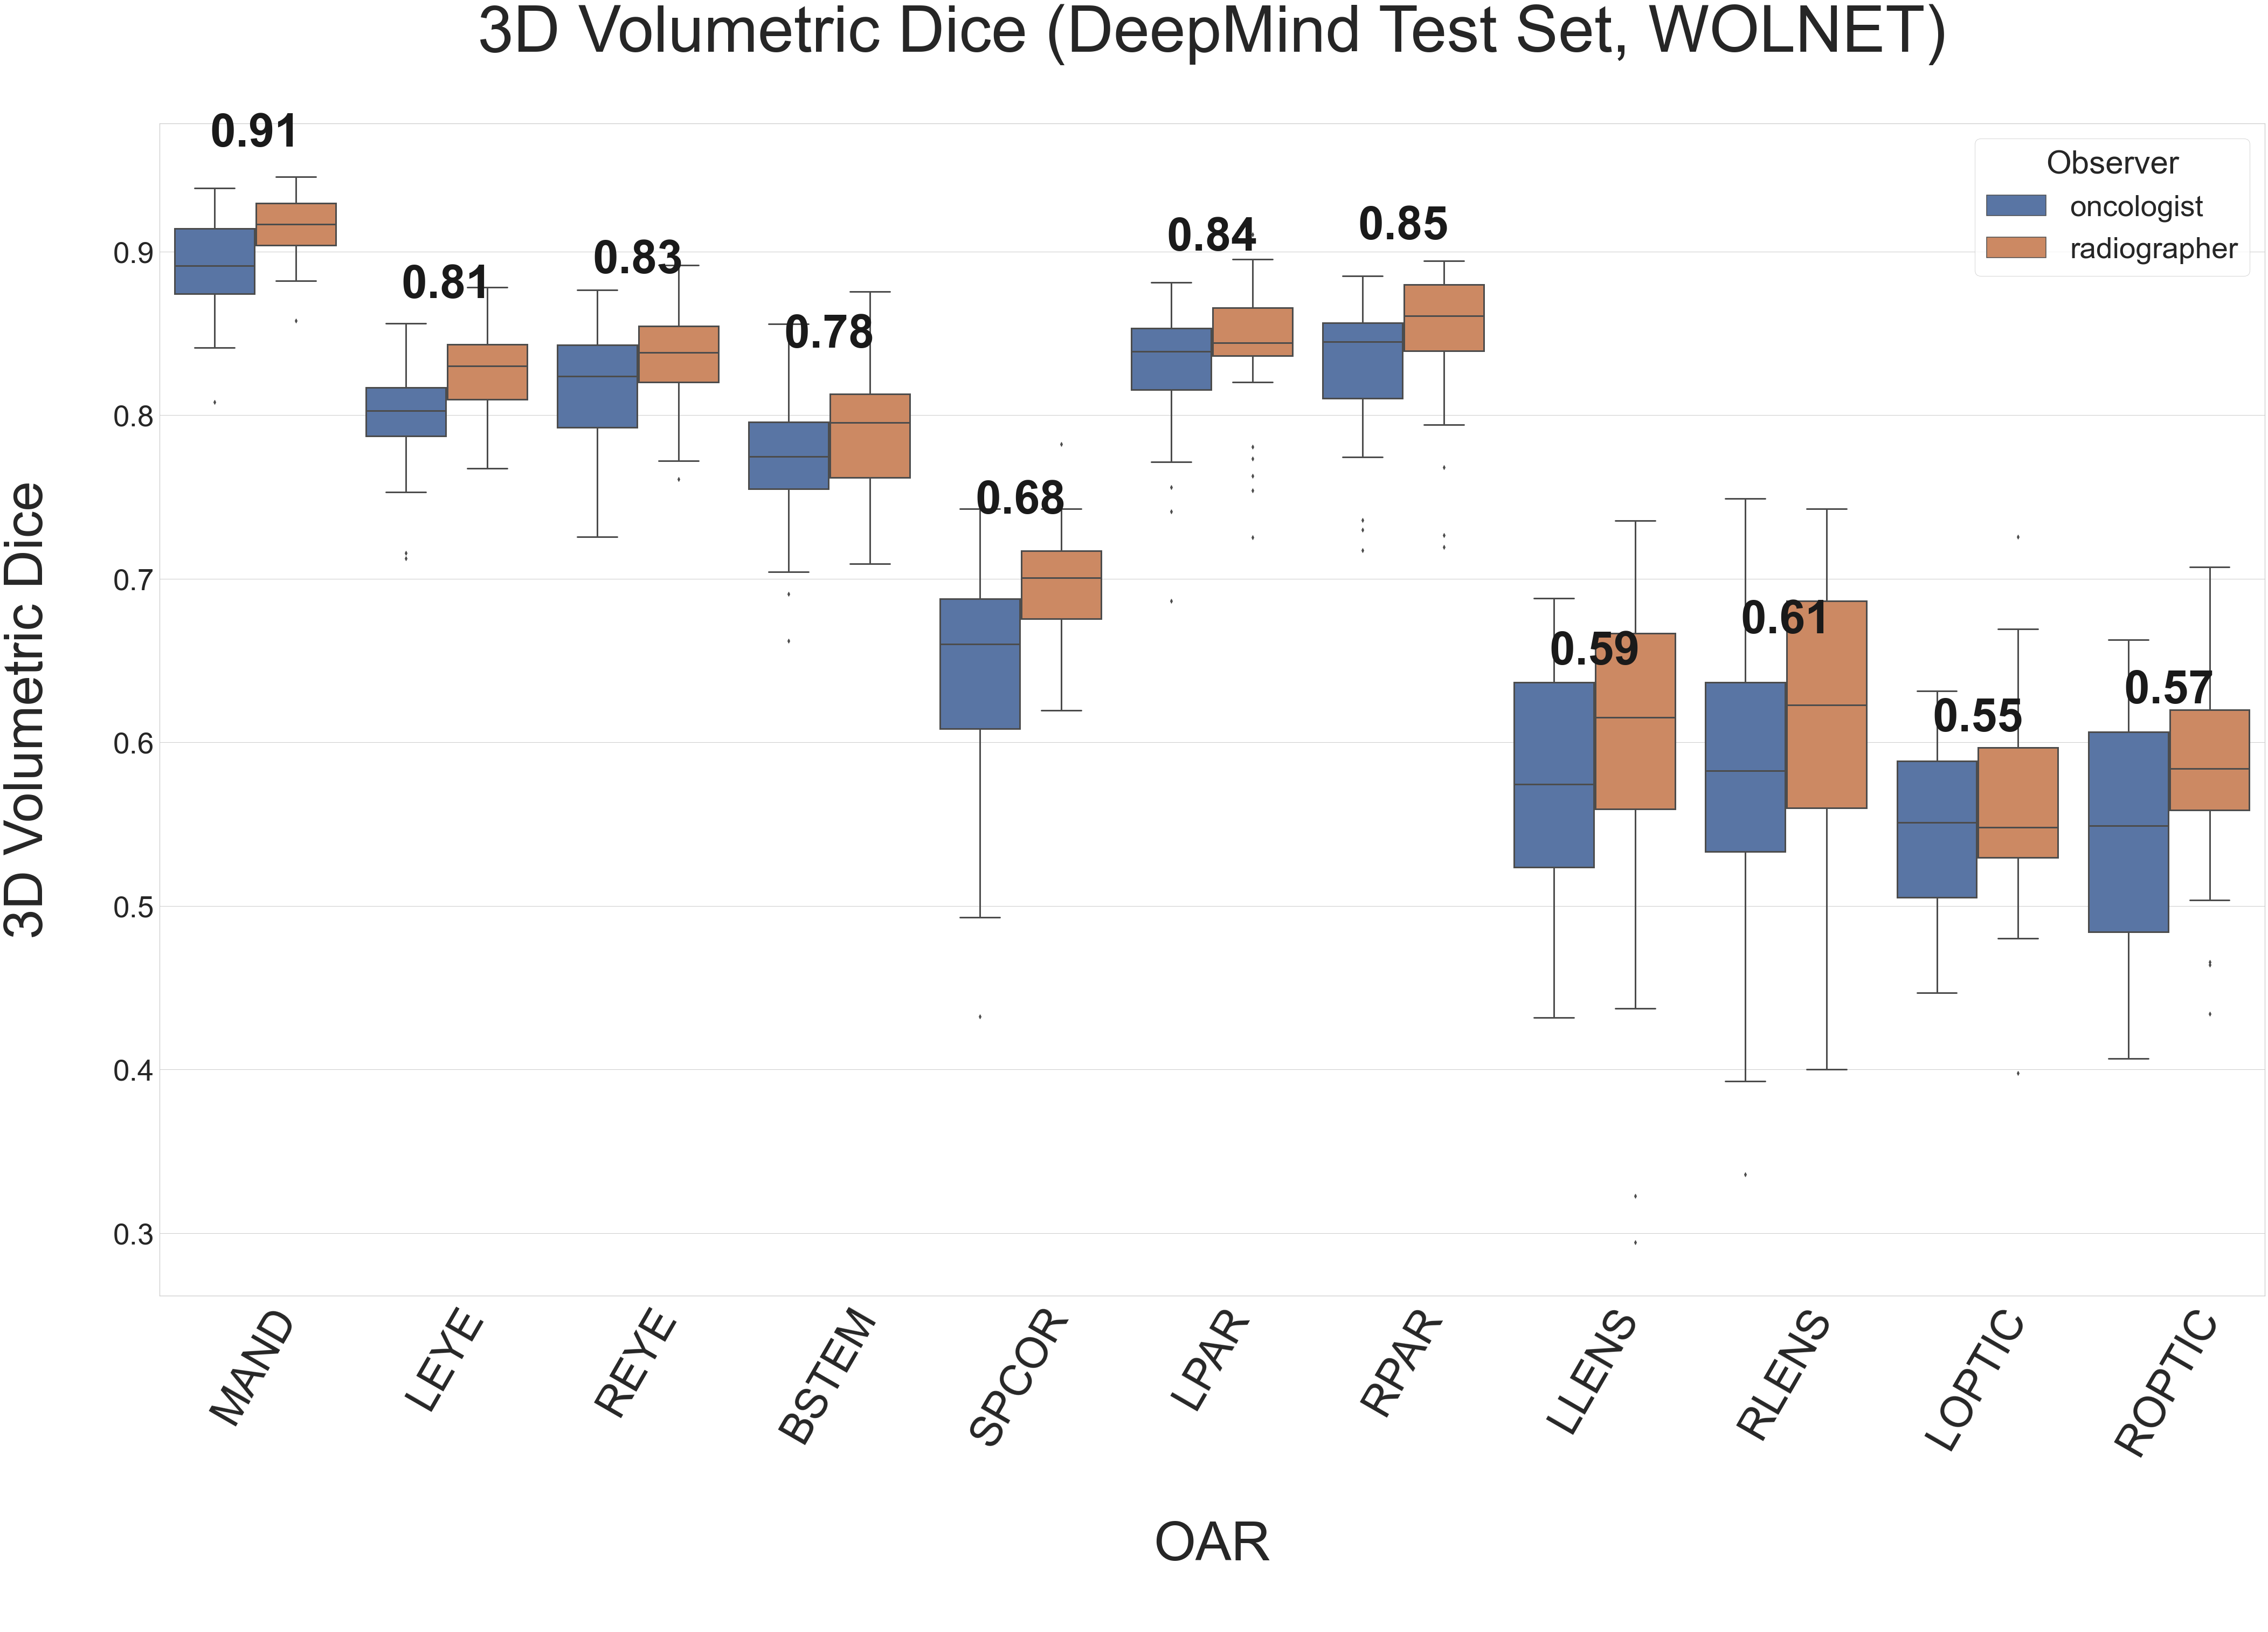

In [63]:
# NOT CORRECTED
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set1")
plt.title('3D Volumetric Dice (DeepMind Test Set, WOLNET)\n', fontsize=120)
rois = ['MAND', 'LEYE', 'REYE', 'BSTEM', 'SPCOR', 'LPAR', 'RPAR', 'LLENS', 'RLENS', 'LOPTIC', 'ROPTIC']
# rois = ['MAND', 'LEYE', 'REYE', 'BSTEM', 'LARYNX', 'SPCOR', 'LPAR', 'RPAR', 'ESOPH', 'LLENS', 'RLENS', 'LACOU', 'RACOU', 'LPLEX', 'RPLEX', 'LIPS', 'LOPTIC', 'ROPTIC', 'CHIASM']
fdata.OAR = fdata.OAR.astype("category")
fdata.OAR.cat.set_categories(rois, inplace=True)
fdata.sort_values(["OAR"])
medians = fdata.groupby(['OAR'])['VolDice'].median()
vertical_offset = fdata['VolDice'].median() * 0.075 # offset from median for display
ax = sea.boxplot(data=fdata, x="OAR", y="VolDice", hue="Observer", width=.85, linewidth=3) # hue_order=chosen,
ax.set_xticklabels(rois, rotation=60, fontsize=80)
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='3D Volumetric Dice\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('3D Volumetric Dice\n', fontsize=100)
# ax.legend_.remove()

Text(0, 0.5, '95%HD\n')

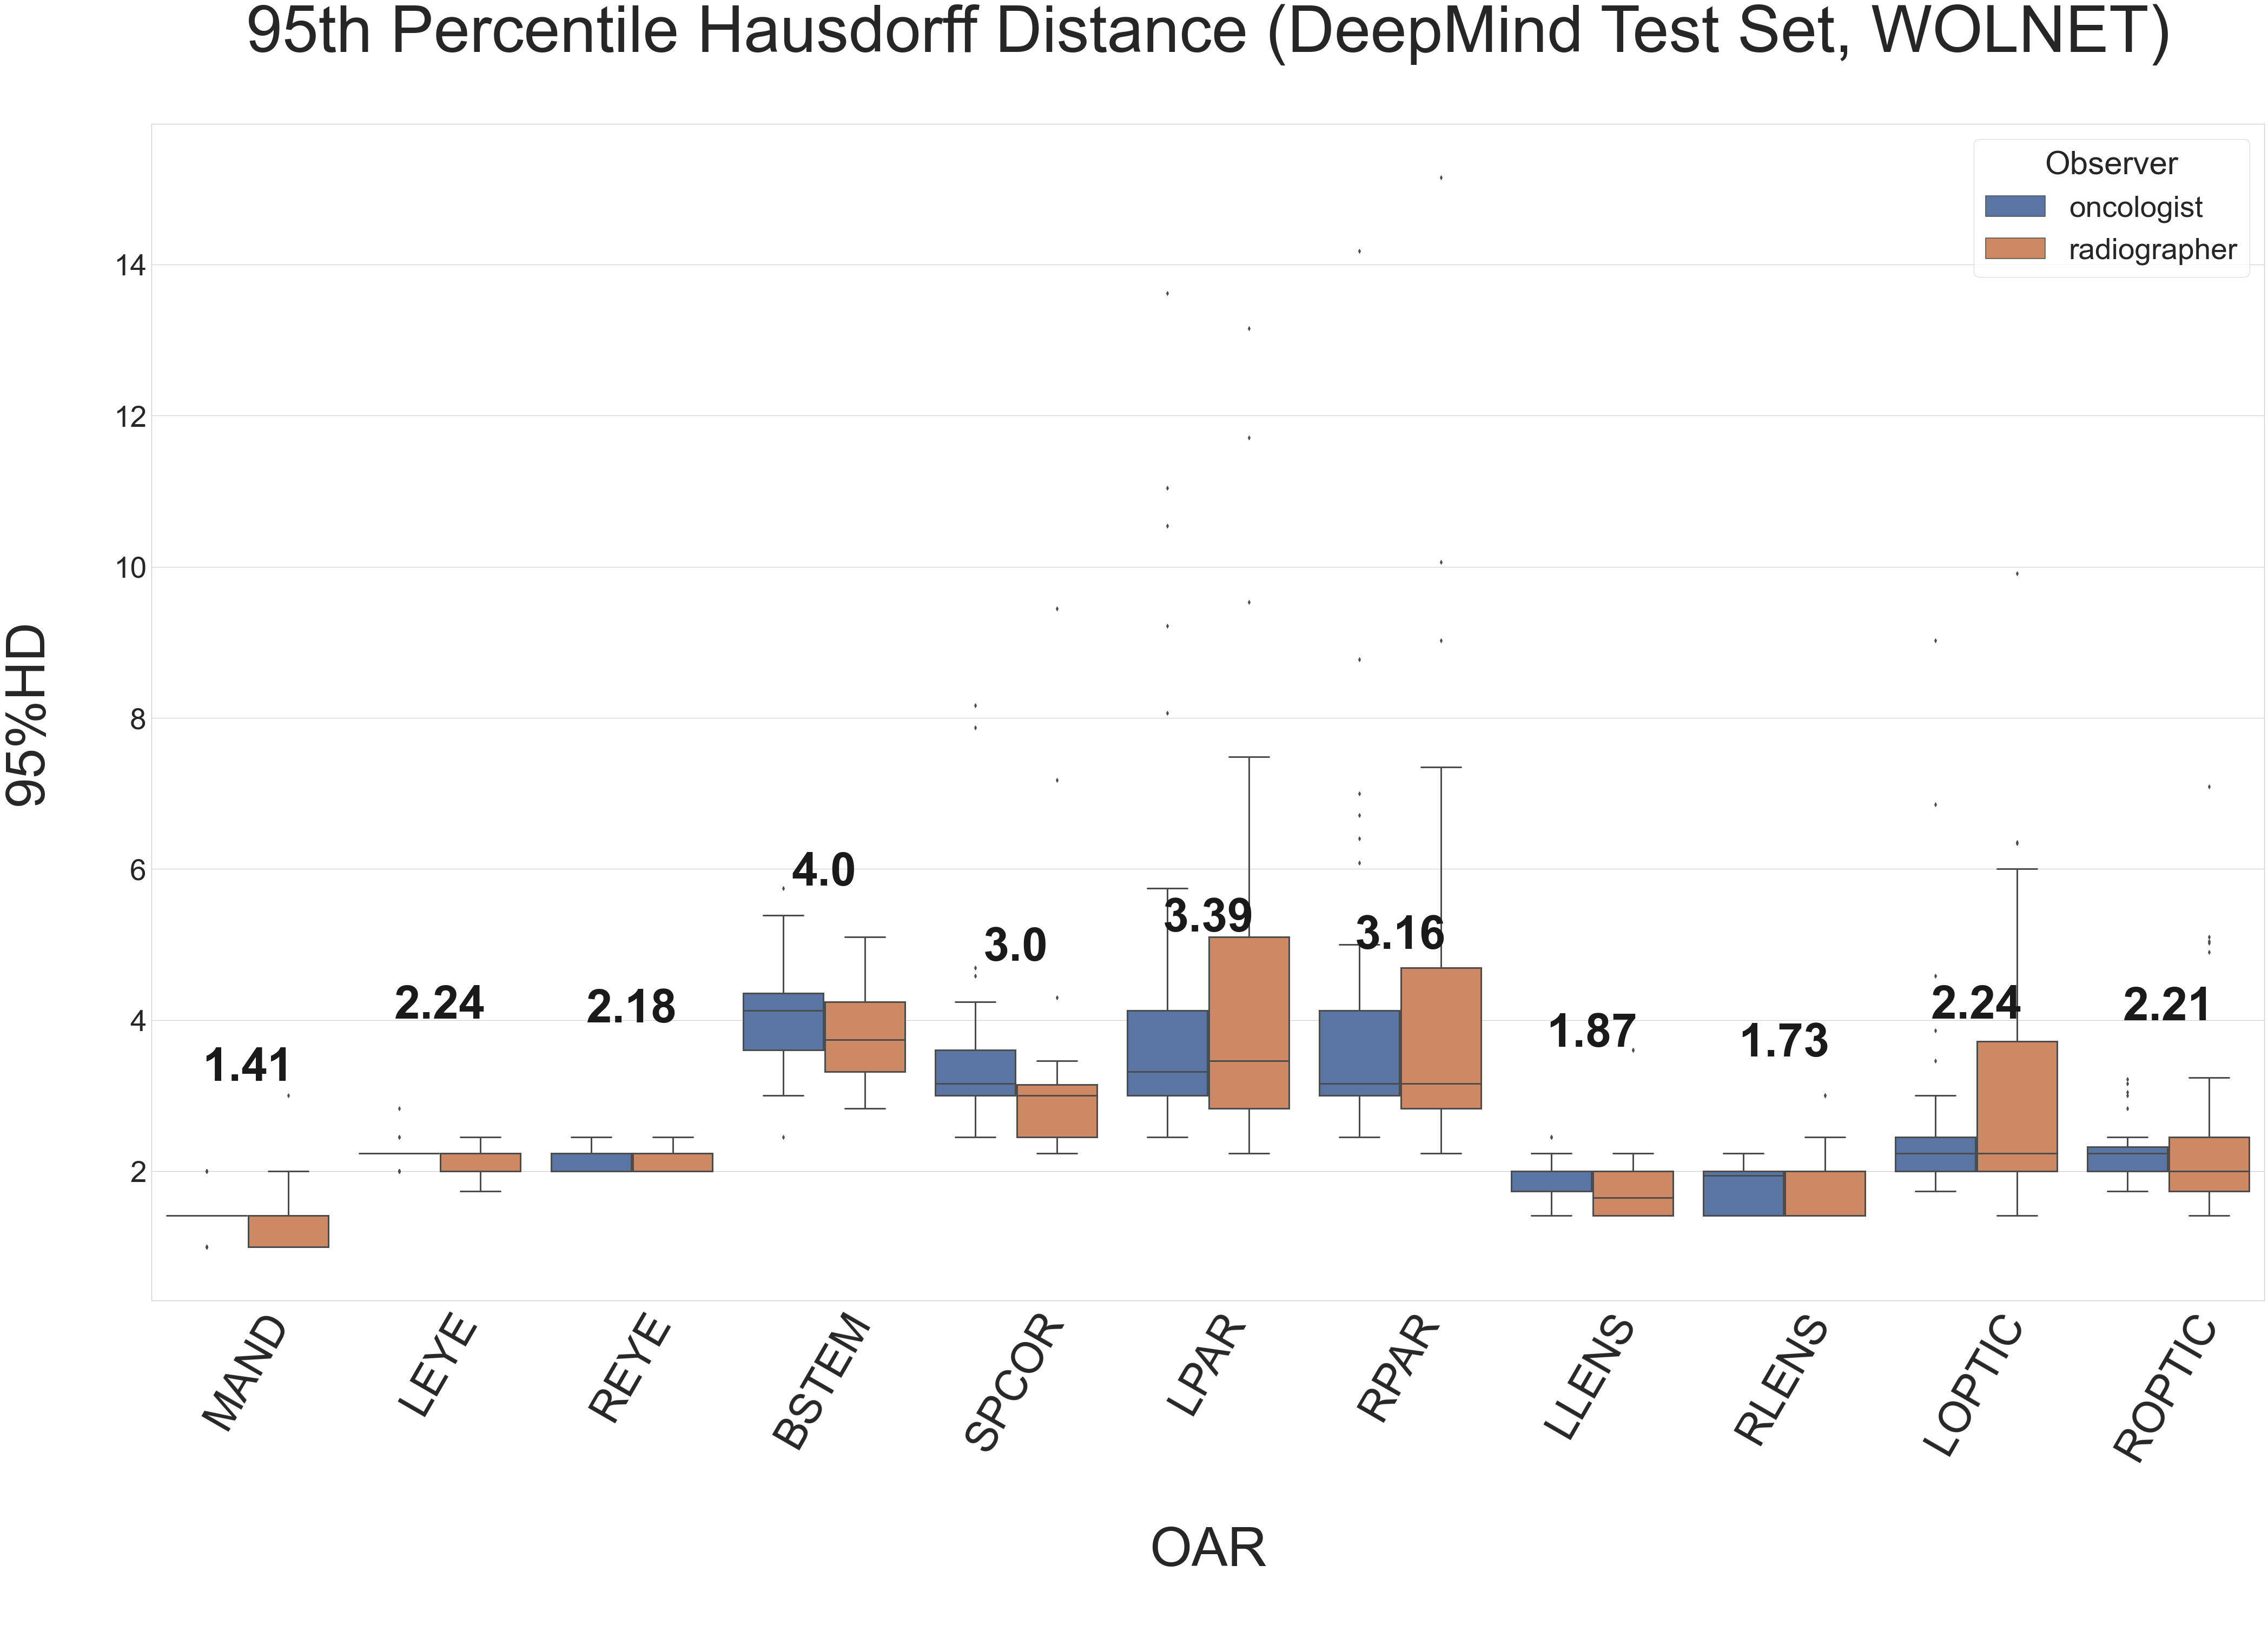

In [73]:
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set2")
plt.title('95th Percentile Hausdorff Distance (DeepMind Test Set, WOLNET)\n', fontsize=120)
ax = sea.boxplot(data=fdata[fdata["95HD"]<17.5], x="OAR", y="95HD", hue="Observer", width=.85, linewidth=3)
ax.set_xticklabels(rois, rotation=60, fontsize=80)
medians = fdata.groupby(['OAR'])['95HD'].median()
vertical_offset = fdata['95HD'].median() * .8 # offset from median for display
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='95%HD\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('95%HD\n', fontsize=100)
# ax.legend_.remove()

In [6]:
targ = sitk.ReadImage('/Users/joemarsilla/Documents/DeepMind/oncologist/0522c0659/CT_IMAGE.nrrd')

In [27]:
a = sitk.StatisticsImageFilter()

In [31]:
a.GetMinimum()

-1024.0

In [29]:
a.Execute(targ)

In [140]:
img = sitk.ReadImage('/Users/joemarsilla/Documents/DeepMind/oncologist/0522c0773/CT_IMAGE.nrrd')

In [146]:
img = sitk.ReadImage('/Users/joemarsilla/Documents/DeepMind/oncologist/0522c0727b/CT_IMAGE.nrrd')

In [148]:
img.GetSpacing()

(0.9765625, 0.9765625, 2.5)

In [137]:
path_

'/Users/joemarsilla/Documents/DeepMind/oncologist/0522c0773/segmentations/'

In [64]:
outputs = torch.from_numpy(np.load(out_path))
targets = torch.from_numpy(np.load(out_path.replace('outs', 'targ')))
outputs, _ = onehot(outputs, targets, argmax=False)

tensor(1)


In [66]:
outputs.size()

torch.Size([1, 2, 213, 497, 497])

In [57]:
dce = met.compute_meandice(outs[0], targ[0])

In [58]:
dce[0][0]

tensor(nan)

In [45]:
h = met.compute_hausdorff_distance(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0), percentile=95, include_background=True)

In [48]:
h[0][0].item()

5.0990195135927845

In [25]:
targets.shape

torch.Size([213, 497, 497])

In [26]:
targ = sitk.ReadImage(path_+deep_classes[k]+'.nrrd')

In [27]:
targ.GetSpacing()

(0.97, 0.97, 2.5)

In [67]:
out_path = f"/Users/joemarsilla/Downloads/deepmind_data_ensemble/outs_{i}_FULL.npy"
outputs = torch.from_numpy(np.load(out_path))

In [69]:
outputs.max()

tensor(19.)

In [144]:
import glob
ims = glob.glob('/Users/joemarsilla/Downloads/deepmind_ensemble/in*')

In [145]:
for path in ims:
    a = np.load(path)
    print(a.shape, path)

(170, 512, 512) /Users/joemarsilla/Downloads/deepmind_ensemble/input_8_FULL.npy
(170, 512, 512) /Users/joemarsilla/Downloads/deepmind_ensemble/input_9_FULL.npy
(170, 512, 512) /Users/joemarsilla/Downloads/deepmind_ensemble/input_17_FULL.npy
(170, 512, 512) /Users/joemarsilla/Downloads/deepmind_ensemble/input_16_FULL.npy
(170, 512, 512) /Users/joemarsilla/Downloads/deepmind_ensemble/input_29_FULL.npy
(170, 512, 512) /Users/joemarsilla/Downloads/deepmind_ensemble/input_28_FULL.npy
(170, 512, 512) /Users/joemarsilla/Downloads/deepmind_ensemble/input_2_FULL.npy
(170, 512, 512) /Users/joemarsilla/Downloads/deepmind_ensemble/input_3_FULL.npy
(170, 512, 512) /Users/joemarsilla/Downloads/deepmind_ensemble/input_23_FULL.npy
(170, 512, 512) /Users/joemarsilla/Downloads/deepmind_ensemble/input_22_FULL.npy
(170, 512, 512) /Users/joemarsilla/Downloads/deepmind_ensemble/input_34_FULL.npy
(170, 512, 512) /Users/joemarsilla/Downloads/deepmind_ensemble/input_33_FULL.npy
(170, 512, 512) /Users/joemarsil